In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import scipy.stats as stats
import os

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 
plt.style.use('ggplot')
sns.color_palette("Paired");
sns.set_theme();

# Data Loading

In [11]:
# setting path to results folder
root_path = '../../../out/pretrained/adept_ablations/lambda'

# list all folders in root path that don't stat with a dot
nets = ['adept_level1_ablation_lambda.run511']

# read pickle file
tf = pd.DataFrame()
sf = pd.DataFrame()
af = pd.DataFrame()

# load statistics files from nets
for net in nets:
    path = os.path.join(root_path, net, 'results')
    with open(os.path.join(path, 'trialframe.csv'), 'rb') as f:
        tf_temp = pd.read_csv(f, index_col=0)
    tf_temp['net'] = net
    tf = pd.concat([tf,tf_temp])

    with open(os.path.join(path, 'slotframe.csv'), 'rb') as f:
        sf_temp = pd.read_csv(f, index_col=0)
    sf_temp['net'] = net
    sf = pd.concat([sf,sf_temp])

    with open(os.path.join(path, 'accframe.csv'), 'rb') as f:
        af_temp = pd.read_csv(f, index_col=0)
    af_temp['net'] = net
    af = pd.concat([af,af_temp])

# cast variables
sf['visible'] = sf['visible'].astype(bool)
sf['bound'] = sf['bound'].astype(bool)
sf['occluder'] = sf['occluder'].astype(bool)
sf['inimage'] = sf['inimage'].astype(bool)
sf['vanishing'] = sf['vanishing'].astype(bool)
sf['alpha_pos'] = 1-sf['alpha_pos']
sf['alpha_ges'] = 1-sf['alpha_ges']

# scale to percentage
sf['TE'] = sf['TE'] * 100

# add surprise as dummy code
tf['control'] = [('control' in set) for set in tf['set']]
sf['control'] = [('control' in set)  for set in sf['set']]

# Calculate Tracking Error (TE)

In [12]:
grouping = (sf.inimage & sf.bound & ~sf.occluder & sf.control)

def get_stats(col):
    return f' M: {col.mean():.3} , STD: {col.std():.3}, Count: {col.count()}'

# When Visible
temp = sf[grouping & sf.visible]
print(f'Tracking Error when visible:' + get_stats(temp['TE']))

# When Occluded
temp = sf[grouping & ~sf.visible]
print(f'Tracking Error when occluded:' + get_stats(temp['TE']))

Tracking Error when visible: M: 3.34 , STD: 4.22, Count: 1873
Tracking Error when occluded: M: 2.78 , STD: 1.66, Count: 492


# Calculate Succesfull Trackings (TE)

In [13]:
# succesfull trackings: In the last visible moment of the target, the slot was less than 10% away from the target
# determine last visible frame numeric
grouping_factors = ['net','set','evalmode','scene','slot']
ff = sf[sf.visible & sf.bound & sf.inimage].groupby(grouping_factors).max()
ff.rename(columns = {'frame':'last_visible'}, inplace = True)
sf = sf.merge(ff[['last_visible']], on=grouping_factors, how='left')

# same for first bound frame
ff = sf[sf.visible & sf.bound & sf.inimage].groupby(grouping_factors).min()
ff.rename(columns = {'frame':'first_visible'}, inplace = True)
sf = sf.merge(ff[['first_visible']], on=grouping_factors, how='left')

# add dummy variable to sf
sf['last_visible'] = (sf['last_visible'] == sf['frame'])

# extract the trials where the target was last visible and threshold the TE
ff = sf[sf['last_visible']] 
ff['tracked_pos'] = (ff['TE'] < 10)
ff['tracked_neg'] = (ff['TE'] >= 10)

# fill NaN with 0
sf = sf.merge(ff[grouping_factors + ['tracked_pos', 'tracked_neg']], on=grouping_factors, how='left')
sf['tracked_pos'].fillna(False, inplace=True)
sf['tracked_neg'].fillna(False, inplace=True)

# Aggreagte over all scenes
temp = sf[(sf['frame']== 1) & ~sf.occluder & sf.control & (sf.first_visible < 20)]
temp = temp.groupby(['set', 'evalmode']).sum()
temp = temp[['tracked_pos', 'tracked_neg']]
temp = temp.reset_index()

temp['tracked_pos_pro'] = temp['tracked_pos'] / (temp['tracked_pos'] + temp['tracked_neg'])
temp['tracked_neg_pro'] = temp['tracked_neg'] / (temp['tracked_pos'] + temp['tracked_neg'])

temp

,set,evalmode,tracked_pos,tracked_neg,tracked_pos_pro,tracked_neg_pro
0,control,open,37,11,0.770833,0.229167


# Mostly Tracked stats

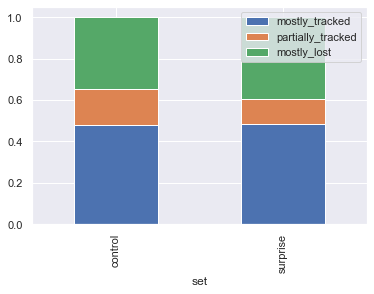

In [14]:
temp = af[af.index == 'OVERALL']
temp['mostly_tracked'] = temp['mostly_tracked'] / temp['num_unique_objects']
temp['partially_tracked'] = temp['partially_tracked'] / temp['num_unique_objects']
temp['mostly_lost'] = temp['mostly_lost'] / temp['num_unique_objects']
g = temp[['mostly_tracked', 'partially_tracked', 'mostly_lost','set']].set_index(['set']).groupby(['set']).mean().plot(kind='bar', stacked=True);

# MOTA 

In [15]:
af[af.index == 'OVERALL'].groupby(['set']).mean()

,idf1,idp,idr,recall,precision,num_unique_objects,mostly_tracked,partially_tracked,mostly_lost,num_false_positives,num_misses,num_switches,num_fragmentations,mota,motp,num_transfer,num_ascend,num_migrate
set,,,,,,,,,,,,,,,,,,
control,0.773828,0.943857,0.655708,0.673474,0.969430,86.0,41.0,15.0,30.0,104.0,1599.0,9.0,31.0,0.650398,0.039370,0.0,9.0,0.0
surprise,0.776620,0.942186,0.660545,0.678911,0.968383,33.0,16.0,4.0,13.0,35.0,507.0,4.0,12.0,0.654212,0.039468,2.0,2.0,0.0


# Gate Openings

In [16]:
grouping = (sf.inimage & sf.bound & ~sf.occluder & sf.control)
temp = sf[grouping & sf.visible]
print(f'Percept gate openings when visible:' + get_stats(temp['alpha_pos'] + temp['alpha_ges']))
temp = sf[grouping & ~sf.visible]
print(f'Percept gate openings when occluded:' + get_stats(temp['alpha_pos'] + temp['alpha_ges']))

Percept gate openings when visible: M: 0.132 , STD: 0.145, Count: 1873
Percept gate openings when occluded: M: 0.00809 , STD: 0.0444, Count: 492
